Region Convergence Results (2000-2020)

In [5]:
import pandas as pd
df = pd.read_csv(r"C:\Users\glori\Downloads\QTM 350 Final Project\wdi_edu_filtered.csv")
df = df[~df['series'].str.contains('_')]

regions = [
    'East Asia & Pacific',
    'Latin America & Caribbean',
    'Middle East, North Africa, Afghanistan & Pakistan',
    'South Asia',
    'Sub-Saharan Africa'
]

edu_levels = ['primary', 'secondary', 'tertiary']

year_cols = [c for c in df.columns if "YR" in c]

df_long = df.melt(
    id_vars=['Country', 'series'],
    value_vars=year_cols,
    var_name='year',
    value_name='enrollment'
)
df_long['year'] = df_long['year'].str.replace('YR', '').astype(int)
df_long = df_long[(df_long['year'] >= 2000) & (df_long['year'] <= 2020)]
world = df_long[df_long['Country'] == "World"]

def compute_convergence(level):
    result = []

    for region in regions:
        region_df = df_long[(df_long['Country'] == region) & (df_long['series'] == level)]
        world_df = world[world['series'] == level]

        r2000 = region_df.loc[region_df['year'] == 2000, 'enrollment'].values[0]
        r2020 = region_df.loc[region_df['year'] == 2020, 'enrollment'].values[0]

        w2000 = world_df.loc[world_df['year'] == 2000, 'enrollment'].values[0]
        w2020 = world_df.loc[world_df['year'] == 2020, 'enrollment'].values[0]

        gap2000 = r2000 - w2000
        gap2020 = r2020 - w2020

        improvement = gap2000 - gap2020  

        result.append([region, level, gap2000, gap2020, improvement])

    return pd.DataFrame(result, columns=['Region','Level','Gap_2000','Gap_2020','Gap_Reduction'])


df_results = pd.concat([compute_convergence(l) for l in edu_levels])

df_results_sorted = df_results.sort_values(["Level", "Gap_Reduction"], ascending=False)
df_results_sorted

# Positive Gap_Reduction indicates convergence towards the world average, while negative indicates divergence.

,Region,Level,Gap_2000,Gap_2020,Gap_Reduction
4,Sub-Saharan Africa,tertiary,-15.099781,-30.509499,15.409718
2,"Middle East, North Africa, Afghanistan & Pakistan",tertiary,-5.927641,-11.402220,5.474579
3,South Asia,tertiary,-10.262691,-11.487999,1.225308
1,Latin America & Caribbean,tertiary,4.333410,15.161251,-10.827841
0,East Asia & Pacific,tertiary,-2.927410,12.944469,-15.871880
2,"Middle East, North Africa, Afghanistan & Pakistan",secondary,-9.257473,-15.780060,6.522587
1,Latin America & Caribbean,secondary,19.908268,20.610397,-0.702129
4,Sub-Saharan Africa,secondary,-34.036251,-31.802059,-2.234192
0,East Asia & Pacific,secondary,2.671848,13.392220,-10.720371
3,South Asia,secondary,-11.963470,0.501328,-12.464798


Enrollment Convergence Line Plots

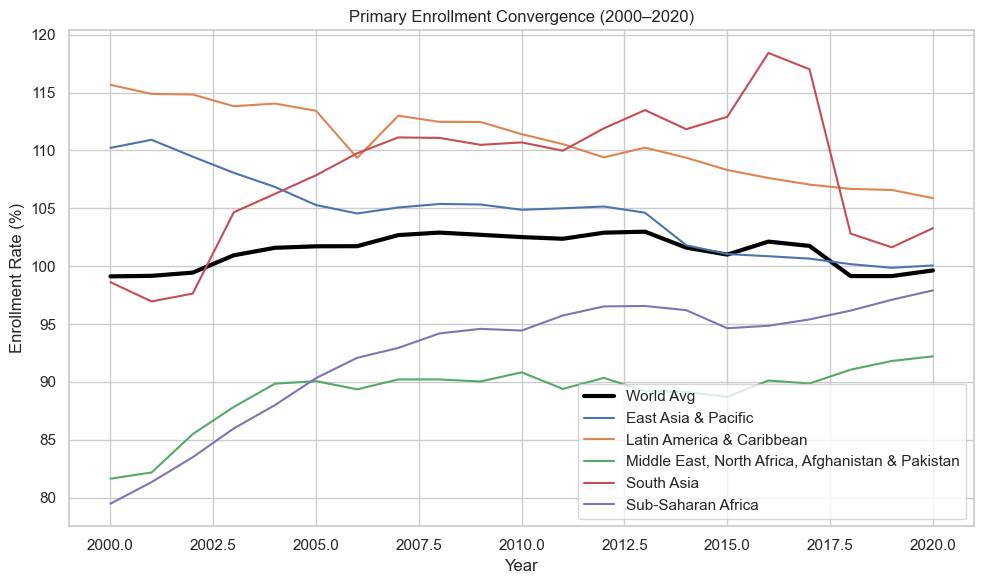

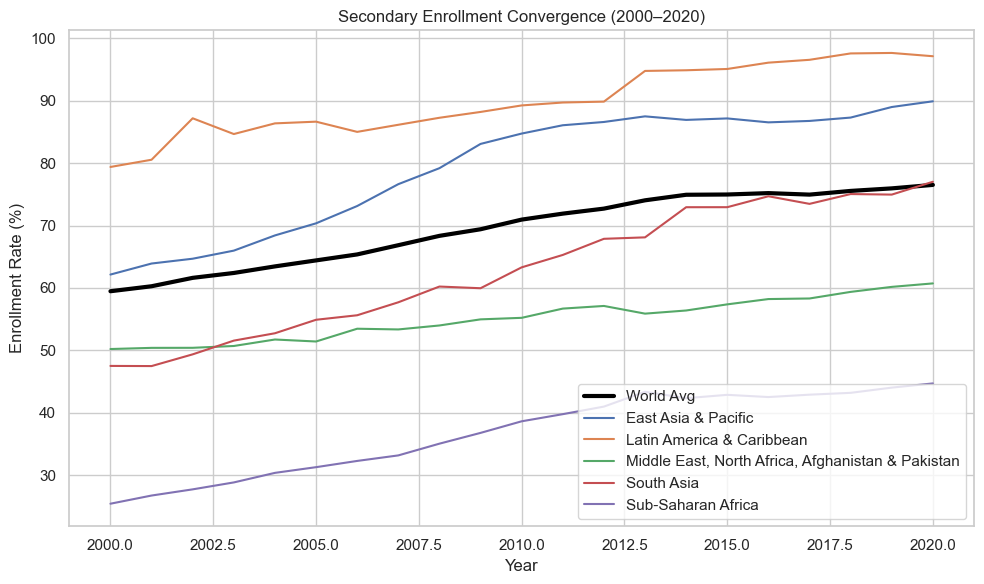

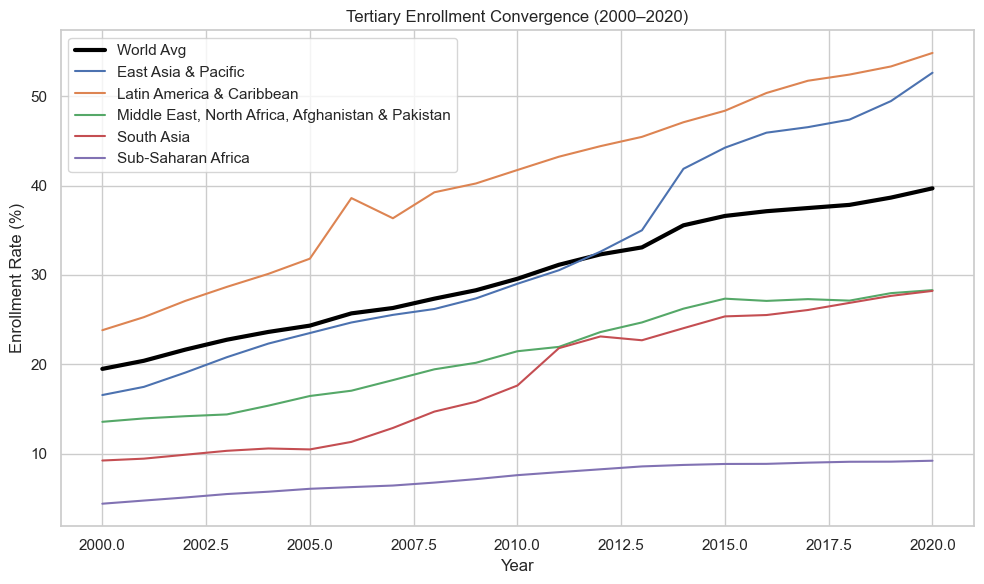

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

world_ts = world[['year','series','enrollment']]

region_ts = df_long[df_long['Country'].isin(regions)]

for level in edu_levels:
    plt.figure()

    w = world_ts[world_ts['series'] == level]
    plt.plot(w['year'], w['enrollment'], label='World Avg', linewidth=3, color='black')

    for reg in regions:
        r = region_ts[(region_ts['Country'] == reg) & (region_ts['series'] == level)]
        plt.plot(r['year'], r['enrollment'], label=reg)

    plt.title(f"{level.capitalize()} Enrollment Convergence (2000–2020)")
    plt.xlabel("Year")
    plt.ylabel("Enrollment Rate (%)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{level}_convergence_lines.png")
    plt.show()

#Showing line plots of enrollment rates over time for each region compared to world average

Enrollment Convergence Bar Plots

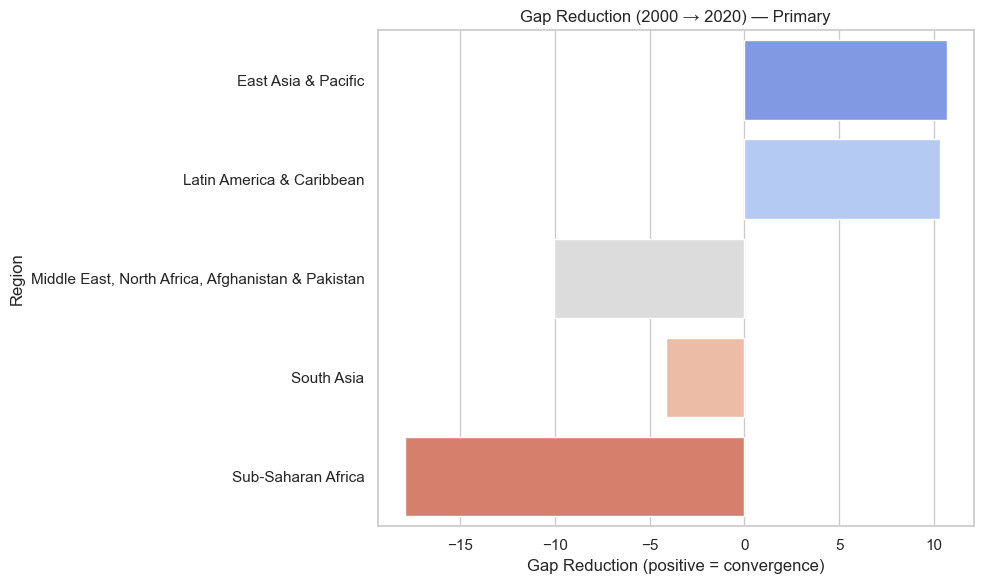

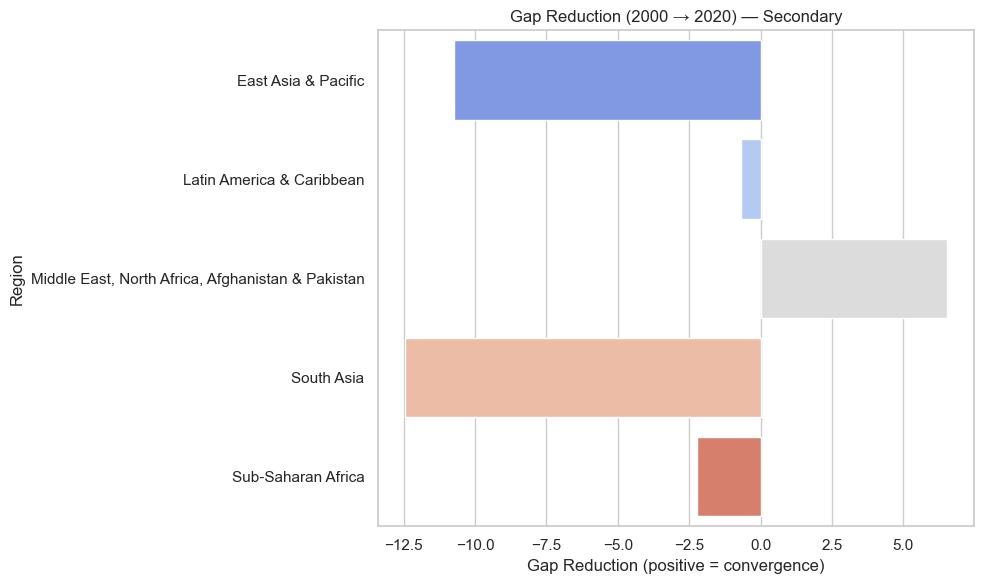

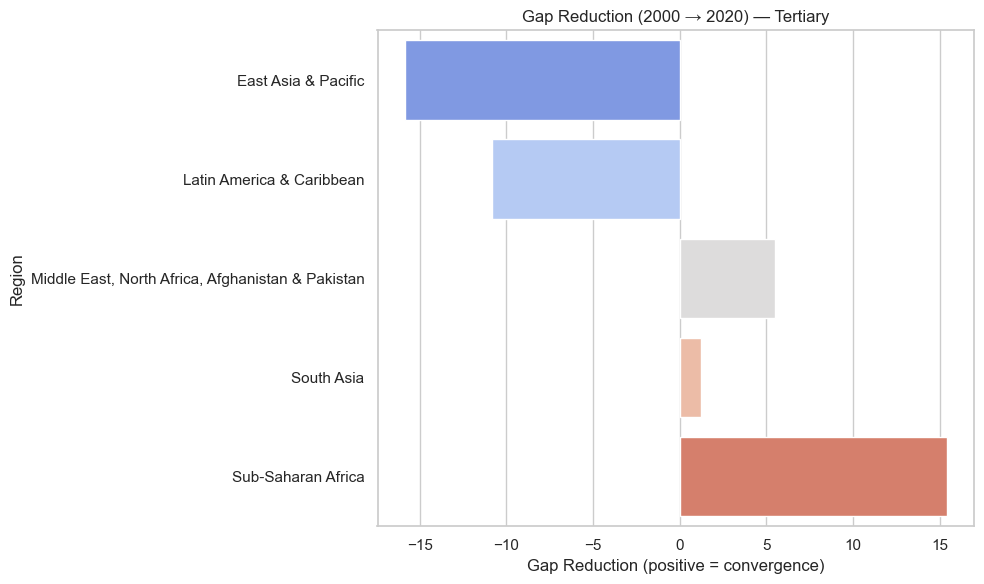

In [7]:
gap_plot_df = df_results.copy()
gap_plot_df['Gap_Reduction'] = gap_plot_df['Gap_2000'] - gap_plot_df['Gap_2020']

for level in edu_levels:
    plt.figure()
    subset = gap_plot_df[gap_plot_df['Level'] == level]

    sns.barplot(
        data=subset,
        x='Gap_Reduction',
        y='Region',
        palette='coolwarm'
    )

    plt.title(f"Gap Reduction (2000 → 2020) — {level.capitalize()}")
    plt.xlabel("Gap Reduction (positive = convergence)")
    plt.ylabel("Region")
    plt.tight_layout()
    plt.savefig(f"{level}_gap_reduction_bars.png")
    plt.show()

#Bar plots showing gap reduction for each region and education level

β-Convergence Regression Analysis

In [9]:
import statsmodels.api as sm

print("\n\n==============================")
print("β-CONVERGENCE REGRESSION RESULTS")
print("==============================\n")

beta_results = []

for level in edu_levels:
    subset = df_results[df_results['Level'] == level].copy()

    subset['Delta_Gap'] = subset['Gap_2020'] - subset['Gap_2000']

    X = sm.add_constant(subset['Gap_2000'])
    y = subset['Delta_Gap']

    model = sm.OLS(y, X).fit()

    print(f"\n--- {level.upper()} LEVEL β-CONVERGENCE ---")
    print(model.summary())

    beta_results.append({
        'Level': level,
        'Beta_Coefficient': model.params['Gap_2000'],
        'Beta_pvalue': model.pvalues['Gap_2000'],
        'Interpretation': (
            "Convergence (β < 0)"
            if model.params['Gap_2000'] < 0
            else "Divergence (β > 0)"
        )
    })

beta_df = pd.DataFrame(beta_results)
beta_df.to_csv("beta_convergence_summary.csv", index=False)

print("\n\nβ-convergence summary:")
print(beta_df.to_string(index=False))

#Showing Primary is strongly converging, Secondary is moderately converging, Tertiary is diverging
#Countries with bigger initial gaps tend to close those gaps faster (for Primary and Secondary levels)



β-CONVERGENCE REGRESSION RESULTS


--- PRIMARY LEVEL β-CONVERGENCE ---
                            OLS Regression Results                            
Dep. Variable:              Delta_Gap   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     43.51
Date:                Sat, 06 Dec 2025   Prob (F-statistic):            0.00709
Time:                        23:48:02   Log-Likelihood:                -12.352
No. Observations:                   5   AIC:                             28.70
Df Residuals:                       3   BIC:                             27.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

c:\Users\glori\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\glori\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\glori\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
